In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from tqdm import tqdm

Read in Training data

In [2]:
training_df = pd.read_csv('data/training_set.csv')
training_metadata_df = pd.read_csv('data/training_set_metadata.csv')

In [3]:
training_metadata_df.head(5)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [4]:
objs = np.unique(training_df.object_id)
passbands = [0, 1, 2, 3, 4, 5]
targets = np.unique(training_metadata_df.target)

Plot example of observation of one object in all 6 LSST passbands

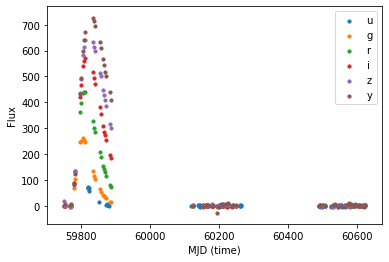

In [5]:
example = training_df[(training_df.object_id == objs[200])]
filters = ['u', 'g', 'r', 'i', 'z', 'y']
for i in np.arange(6):
    ex = example[(example.passband == passbands[i])]
    plt.scatter(ex.mjd, ex.flux, s=10, label=filters[i])
plt.xlabel('MJD (time)')
plt.ylabel('Flux')
plt.legend()
plt.savefig('example_observation.png', dpi=200, bbox_inches='tight')
plt.show()

# Normalize and interpolate time series

Here, we need to make all of the light curve data into a consistent format such that the observations can be used as inputs for a neural network. First, we use a min-max normalization for both the flux and time of the observations. We then interpolate the data linearly and select 100 time points for each observation in each of the 6 passbands.

In [6]:
X = []
y = []
for obj in tqdm(objs):
    data = training_df[training_df.object_id == obj]
    min_mjd = np.min(data.mjd)
    max_mjd = np.max(data.mjd)
    min_flux = np.min(data.flux)
    max_flux = np.max(data.flux)
    flux_all = []
    for passband in passbands:
        data = training_df.loc[(training_df.object_id == obj) & (training_df.passband == passband)]
        norm_mjd = (data.mjd - min_mjd)/(max_mjd - min_mjd)
        norm_flux = (data.flux - min_flux)/(max_flux - min_flux)
        mjd_interp = np.linspace(np.min(norm_mjd), np.max(norm_mjd), 100)
        interp = interp1d(norm_mjd, norm_flux, kind='linear')
        flux_interp = interp(mjd_interp)
        flux_all += [flux_interp]
    X += [flux_all]
    y += [1.*(targets == int(training_metadata_df.loc[training_metadata_df.object_id == obj].target))]

100%|██████████| 7848/7848 [07:23<00:00, 17.71it/s]


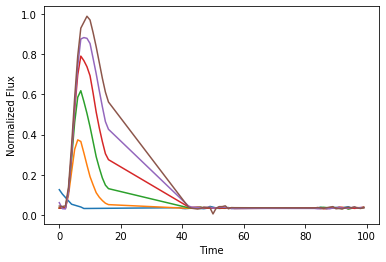

In [7]:
for passband in passbands:
    plt.plot(np.arange(len(X[200][passband])), X[200][passband])
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.show()

# Deep Learning

In [8]:
import keras
import tensorflow as tf
import seaborn as sn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


The cells below first compute the fraction of examples of each class within the training data. Then which define the weighted logarithmic loss function which will be used to train the network.

In [9]:
N = []
for i in np.arange(len(targets)):
    N += [len(training_metadata_df.loc[training_metadata_df.target == targets[i]])]
w = N/np.sum(N)
print(targets)
print(w)

[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]
[0.01924057 0.06307339 0.117737   0.15201325 0.02331804 0.00382263
 0.06167176 0.01299694 0.125      0.02650357 0.04714577 0.29472477
 0.03045362 0.02229867]


In [10]:
def LogLoss(y_true, y_pred):
    y_clip = tf.clip_by_value(y_pred, 1e-15, 1-1e-15)
    loss = -(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(y_clip), axis=0)/w))
    return loss

Stratify the training/validation data such that the ratio of examples is the same for both. We use an 80/20 train to validation ratio. This produces 6,278 training examples and 1,570 validation examples.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37, stratify=y)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
num_classes = len(targets)

Now we define the architecture of our CNN. We use 3 2D canvolutional layers, 2 dense layers, and an output layer. We add dropout layers with a dropout rate of 0.5 to reduce overfitting.

In [19]:
activation = 'relu'
dropout_rate = 0.5
CNN_model = Sequential()
CNN_model.add(Reshape((6, 100, 1), input_shape=(6,100)))

CNN_model.add(Conv2D(8, kernel_size=(2, 5), activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Conv2D(16, kernel_size=(2, 5), activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Conv2D(32, kernel_size=(3, 5), activation=activation))
CNN_model.add(Dropout(dropout_rate))

CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Dense(32, activation=activation))
CNN_model.add(Dropout(dropout_rate))

CNN_model.add(Dense(num_classes, activation='softmax'))
print(CNN_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 6, 100, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 96, 8)          88        
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 96, 8)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 92, 16)         1296      
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 92, 16)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 88, 32)         7712      
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 88, 32)        

We use the adam optimizer which automatically adjusts the learning rate of individual parameters. We train for 200 epochs, after which we see little change in the loss of the validation set.

In [20]:
CNN_model.compile(loss=LogLoss,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [21]:
epochs = 200
batch_size = 100
CNN_history = CNN_model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            shuffle=True,
                            validation_data=(X_test, y_test))

Train on 6278 samples, validate on 1570 samples
Epoch 1/200
6278/6278 [==============================] - 8s 1ms/step - loss: 2.6359 - accuracy: 0.1129 - val_loss: 2.6305 - val_accuracy: 0.1611
Epoch 2/200
6278/6278 [==============================] - 7s 1ms/step - loss: 2.5982 - accuracy: 0.1496 - val_loss: 2.6336 - val_accuracy: 0.0261
Epoch 3/200
6278/6278 [==============================] - 9s 1ms/step - loss: 2.5566 - accuracy: 0.1636 - val_loss: 2.6371 - val_accuracy: 0.1268
Epoch 4/200
6278/6278 [==============================] - 8s 1ms/step - loss: 2.5179 - accuracy: 0.1865 - val_loss: 2.6393 - val_accuracy: 0.1280
Epoch 5/200
6278/6278 [==============================] - 8s 1ms/step - loss: 2.4715 - accuracy: 0.1786 - val_loss: 2.5417 - val_accuracy: 0.1535
Epoch 6/200
6278/6278 [==============================] - 8s 1ms/step - loss: 2.4164 - accuracy: 0.1677 - val_loss: 2.5206 - val_accuracy: 0.1605
Epoch 7/200
6278/6278 [==============================] - 8s 1ms/step - loss: 2.350

Epoch 57/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.4947 - accuracy: 0.3114 - val_loss: 1.5802 - val_accuracy: 0.3127
Epoch 58/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.5460 - accuracy: 0.3038 - val_loss: 1.6163 - val_accuracy: 0.2904
Epoch 59/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.4815 - accuracy: 0.3082 - val_loss: 1.4578 - val_accuracy: 0.3535
Epoch 60/200
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4575 - accuracy: 0.3065 - val_loss: 1.5860 - val_accuracy: 0.3146
Epoch 61/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.4495 - accuracy: 0.3226 - val_loss: 1.5458 - val_accuracy: 0.3357
Epoch 62/200
6278/6278 [==============================] - 8s 1ms/step - loss: 1.5707 - accuracy: 0.2983 - val_loss: 1.5258 - val_accuracy: 0.3516
Epoch 63/200
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4779 - accuracy: 0.3101 - val_loss: 1.5547 -

Epoch 113/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.2420 - accuracy: 0.3582 - val_loss: 1.3698 - val_accuracy: 0.3688
Epoch 114/200
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2313 - accuracy: 0.3568 - val_loss: 1.4086 - val_accuracy: 0.3675
Epoch 115/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.2123 - accuracy: 0.3676 - val_loss: 1.3698 - val_accuracy: 0.3726
Epoch 116/200
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2437 - accuracy: 0.3638 - val_loss: 1.3973 - val_accuracy: 0.3682
Epoch 117/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.2529 - accuracy: 0.3632 - val_loss: 1.4389 - val_accuracy: 0.3745
Epoch 118/200
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2533 - accuracy: 0.3606 - val_loss: 1.4671 - val_accuracy: 0.3535
Epoch 119/200
6278/6278 [==============================] - 12s 2ms/step - loss: 1.2219 - accuracy: 0.3584 - val_loss: 

Epoch 169/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.1438 - accuracy: 0.3871 - val_loss: 1.5417 - val_accuracy: 0.3898
Epoch 170/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.1083 - accuracy: 0.3934 - val_loss: 1.4383 - val_accuracy: 0.3847
Epoch 171/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.2046 - accuracy: 0.3901 - val_loss: 1.5114 - val_accuracy: 0.3771
Epoch 172/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.1389 - accuracy: 0.3764 - val_loss: 1.4270 - val_accuracy: 0.3739
Epoch 173/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.1325 - accuracy: 0.3879 - val_loss: 1.4996 - val_accuracy: 0.3847
Epoch 174/200
6278/6278 [==============================] - 7s 1ms/step - loss: 1.1430 - accuracy: 0.3891 - val_loss: 1.5010 - val_accuracy: 0.3764
Epoch 175/200
6278/6278 [==============================] - 8s 1ms/step - loss: 1.1480 - accuracy: 0.3813 - val_loss: 1

In [22]:
print('log loss:', CNN_history.history['val_loss'][-1])
print('accuracy:', CNN_history.history['val_accuracy'][-1])

log loss: 1.4186616080581762
accuracy: 0.379617840051651


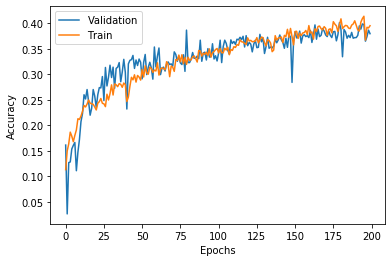

In [23]:
plt.plot(CNN_history.history['val_accuracy'], label='Validation')
plt.plot(CNN_history.history['accuracy'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('CNN_acc_200_epochs.png', dpi=200, bbox_inches='tight')
plt.show()

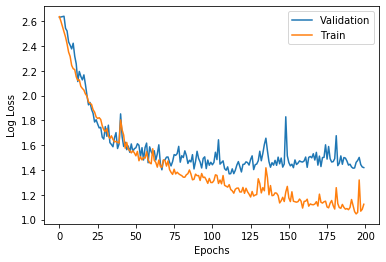

In [24]:
plt.plot(CNN_history.history['val_loss'], label='Validation')
plt.plot(CNN_history.history['loss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
#plt.savefig('CNN_loss_200_epochs.png', dpi=200, bbox_inches='tight')
plt.show()

# Error Analysis

The confusion matrix for the predictions on the validation set is shown below. There are some classes which the model predicts very well (e.g. class 3), while the model does very poorly for other classes (e.g. class 12).

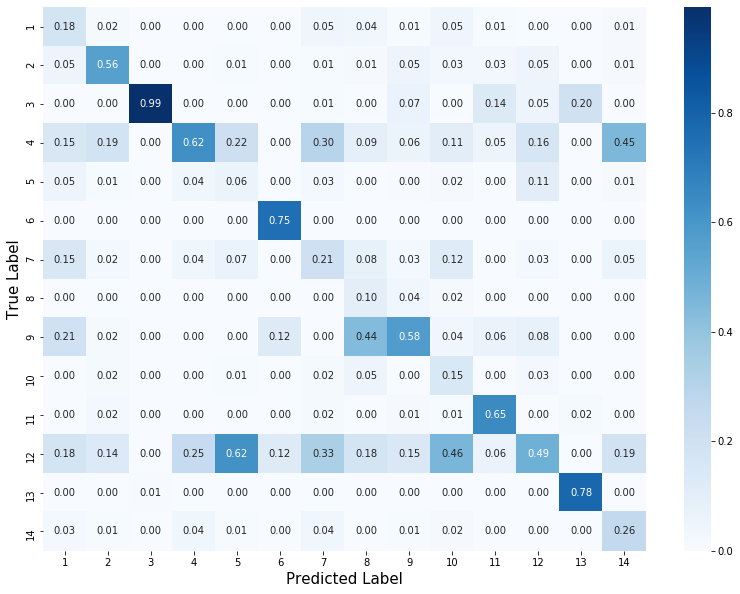

In [111]:
test_pred = CNN_model.predict(X_test)
CNN_cf = confusion_matrix(y_test.argmax(axis=1), test_pred.argmax(axis=1))
CNN_cf_norm = CNN_cf / CNN_cf.sum(axis=0)

plt.figure(figsize = (13.5,10))
sn.heatmap(CNN_cf_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1,15), yticklabels=np.arange(1,15))
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
#plt.savefig('CNN_confusion_matrix_200_epochs.png', dpi=200, bbox_inches='tight')
plt.show()

Now we want to look at some misclassified examples to see what went wrong. From the confusion matrix, we see that objects in class 12 are often misclassified, especially as class 5. Below, we plot one such misclassified example (solid lines), overtop of an object from class 5 that was correctly classified. We see that the lightcurves have very similar characteristics, namely a single peak in time. It is likely that the information that could separate these classes comes from the absolute flux of the peak, which has been removed by our normalization. This example shows one limitation of our normalization scheme for the light curves.

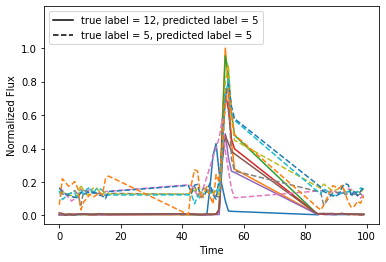

In [113]:
obj_ind_12 = np.where(y_test[:,11] == 1.)[0][10]
obj_ind_5 = np.where(y_test[:,4] == 1.)[0][3]
pred_lab_12 = np.argmax(test_pred[obj_ind_12])+1
pred_lab_5 = np.argmax(test_pred[obj_ind_5])+1
for passband in passbands:
    plt.plot(np.arange(len(X_test[obj_ind_12][passband])), X_test[obj_ind_12][passband])
for passband in passbands:
    plt.plot(np.arange(len(X_test[obj_ind_5][passband])), X_test[obj_ind_5][passband], ls='--')
plt.plot([], [], c='k', label='true label = 12, predicted label = {}'.format(pred_lab_12))
plt.plot([], [], c='k', ls='--', label='true label = 5, predicted label = {}'.format(pred_lab_5))
plt.ylim(-0.05, 1.25)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.legend(loc='upper left')
#plt.savefig('error_example.png', dpi=200, bbox_inches='tight')
plt.show()